# Determine Contribution of Metadata to Feature Differences

We perform an analysis of variance (ANOVA) model to determine if metadata information or real biology treatments contribute to observed differences in each cell painting feature.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
col_types <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_well_position = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_plate_ID = readr::col_character(),
    Metadata_plate_filename = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_batch = readr::col_character()
)

profile_file <- file.path("data", "core_batch_profiles.tsv")
data_df <- readr::read_tsv(profile_file, col_types = col_types)

print(dim(data_df))
head(data_df)

[1] 300 303


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Metadata_batch,⋯,Nuclei_Texture_Correlation_Mito_20_03,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_Entropy_AGP_20_03,Nuclei_Texture_Entropy_DNA_20_03,Nuclei_Texture_InfoMeas1_DNA_10_01,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InfoMeas2_ER_20_03,Nuclei_Texture_SumAverage_DNA_20_03
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
217755,B02,217755,217755,B02,BZ017,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,⋯,0.8869840,0.08892135,0.6781628,2.0195468,0.68140980,-0.7647829,0.3554712,-0.3265789,-0.4996050,-2.2139413
217755,B03,217755,217755,B03,WT002,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,⋯,1.0175293,-1.21681764,-0.9109297,0.2794582,-1.64707430,-1.2663570,1.4120509,1.4343979,-2.1603953,-0.9358300
217755,B04,217755,217755,B04,WT008,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,⋯,-1.2739765,1.52490953,0.2377458,-0.4627884,1.00318791,0.2438529,-1.7673887,-0.9872683,1.3740530,0.5621754
217755,B05,217755,217755,B05,WT009,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,⋯,0.2666923,0.79291140,1.2659797,0.9035151,0.40879932,0.3975182,0.7909181,-1.1144146,0.7827694,-0.3687514
217755,B06,217755,217755,B06,BZ018,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,⋯,-1.1616470,2.65040099,1.3879192,0.6748334,2.07178870,0.7262738,-2.5334004,-2.8428992,2.0770588,0.9485880
217755,B07,217755,217755,B07,WT011,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,⋯,0.3246815,1.07457402,1.3194522,1.1467230,0.05893828,-0.1663964,0.4221956,-1.0898047,-0.1956756,0.2697604


In [3]:
cp_features <- colnames(
    data_df %>% dplyr::select(-starts_with("Metadata_"))
    )

num_cp_features <- length(cp_features)
print(num_cp_features)

[1] 292


In [4]:
all_results <- list()
for (feature in cp_features) {
    # Build formula call
    formula_call = paste(
        feature, "~",
        "Metadata_clone_type", "+",
        "Metadata_treatment", "+",
        "Metadata_batch", "+",
        "Metadata_plate_ID", "+",
        "Metadata_clone_number", "+",
        "Metadata_Well"
    )
    
    aov.out <- aov(
        formula = as.formula(formula_call),
        data = data_df
    )
    
    results <- broom::tidy(aov.out) %>%
        dplyr::mutate(feature = feature)
    
    all_results[[feature]] <- results
}

In [5]:
full_results_df <- do.call(rbind, all_results)

full_results_df <- full_results_df %>%
    dplyr::mutate(neg_log_p = -log10(p.value)) %>%
    tidyr::drop_na()

full_results_df$term <- factor(
    full_results_df$term, levels = c(
        "Metadata_batch",
        "Metadata_plate_ID",
        "Metadata_Well",
        "Metadata_treatment",
        "Metadata_clone_number",
        "Metadata_clone_type"
    )
)

print(dim(full_results_df))
head(full_results_df, 6)

[1] 1752    8


term,df,sumsq,meansq,statistic,p.value,feature,neg_log_p
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,1,20.980116,20.980116,23.999666,1.817242e-06,Cells_AreaShape_Compactness,5.7405872
Metadata_treatment,1,7.480601,7.480601,8.557242,3.785997e-03,Cells_AreaShape_Compactness,2.4218198
Metadata_batch,2,3.862046,1.931023,2.208944,1.121411e-01,Cells_AreaShape_Compactness,0.9502351
Metadata_plate_ID,2,4.230033,2.115017,2.419419,9.123468e-02,Cells_AreaShape_Compactness,1.0398400
Metadata_clone_number,7,269.041450,38.434493,43.966152,4.249690e-39,Cells_AreaShape_Compactness,38.3716428
Metadata_Well,56,58.195661,1.039208,1.188776,1.905641e-01,Cells_AreaShape_Compactness,0.7199588


Picking joint bandwidth of 1.82
Picking joint bandwidth of 1.82


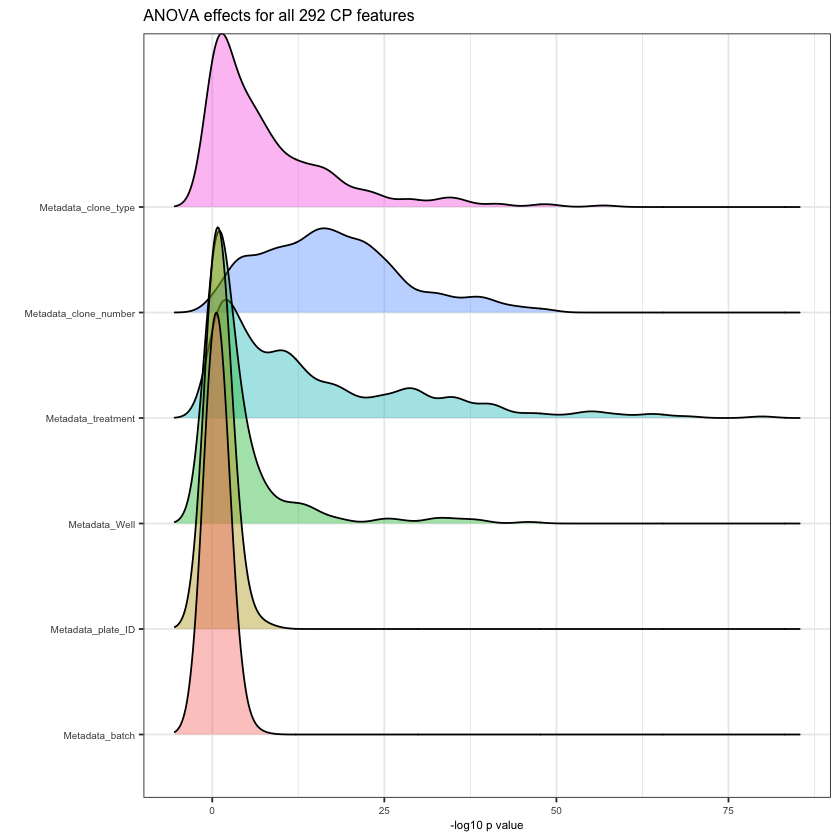

In [6]:
difference_contribution_gg <- ggplot(full_results_df, aes(x = neg_log_p, y = term)) +
    ggridges::geom_density_ridges(aes(fill = term),
                                  alpha = 0.4,
                                  scale = 4) +
    theme_bw() +
    theme(legend.position = "none") +
    xlab("-log10 p value") +
    ylab("") +
    ggtitle(paste("ANOVA effects for all", num_cp_features, "CP features")) +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7),
          title = element_text(size = 8))

out_file <- file.path("figures", "anova_effect_term_distributions.png")
ggsave(out_file, dpi = 400, height = 5, width = 4)

difference_contribution_gg

## Investigate specific features

In [7]:
feature_focus_df <- full_results_df %>%
    reshape2::dcast(feature ~ term, value.var = "neg_log_p")

head(feature_focus_df)

,feature,Metadata_batch,Metadata_plate_ID,Metadata_Well,Metadata_treatment,Metadata_clone_number,Metadata_clone_type
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Cells_AreaShape_Compactness,0.95023513,1.039840040,0.7199588,2.4218198,38.371643,5.7405872
2,Cells_AreaShape_EulerNumber,0.42870030,0.304953803,2.3046654,0.0772718,14.617050,16.6705185
3,Cells_AreaShape_Extent,5.48179767,0.004440204,0.6750717,11.6019618,40.320430,1.1806843
4,Cells_AreaShape_FormFactor,4.75925190,4.587607491,4.2037969,5.4415845,40.540553,21.5958008
5,Cells_AreaShape_Orientation,0.06339644,0.748568062,2.1952895,0.3084569,1.338759,0.1668661
6,Cells_AreaShape_Solidity,1.29563304,1.336134074,1.0386558,0.3209243,26.391002,12.3696394


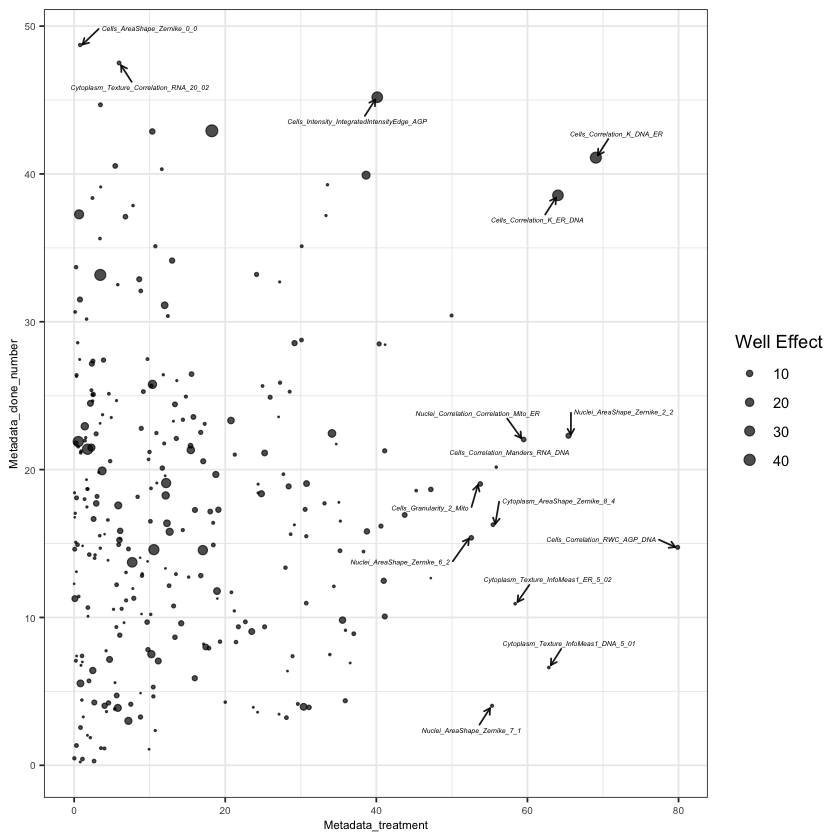

In [8]:
label_logic <- (
    (
        feature_focus_df$Metadata_treatment > 50
    ) | (
        feature_focus_df$Metadata_clone_number > 45
    )
    )

feature_interpret_gg <- ggplot(feature_focus_df,
       aes(x = Metadata_treatment,
           y = Metadata_clone_number,
           size = Metadata_Well)) +
    geom_point(alpha = 0.7) + 
    geom_text_repel(data = subset(feature_focus_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.7,
                    point.padding = 0.2,
                    segment.size = 0.5,
                    segment.alpha = 0.9,
                    size = 1.45,
                    fontface = "italic",
                    aes(label = feature,
                        x = Metadata_treatment,
                        y = Metadata_clone_number)) +
    scale_size_continuous(name = "Well Effect", range = c(0.1, 3)) +
    theme_bw() +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7))

out_file <- file.path("figures", "anova_effect_term_features_clone_vs_treatment.png")
ggsave(out_file, dpi = 400, height = 5, width = 5)

feature_interpret_gg

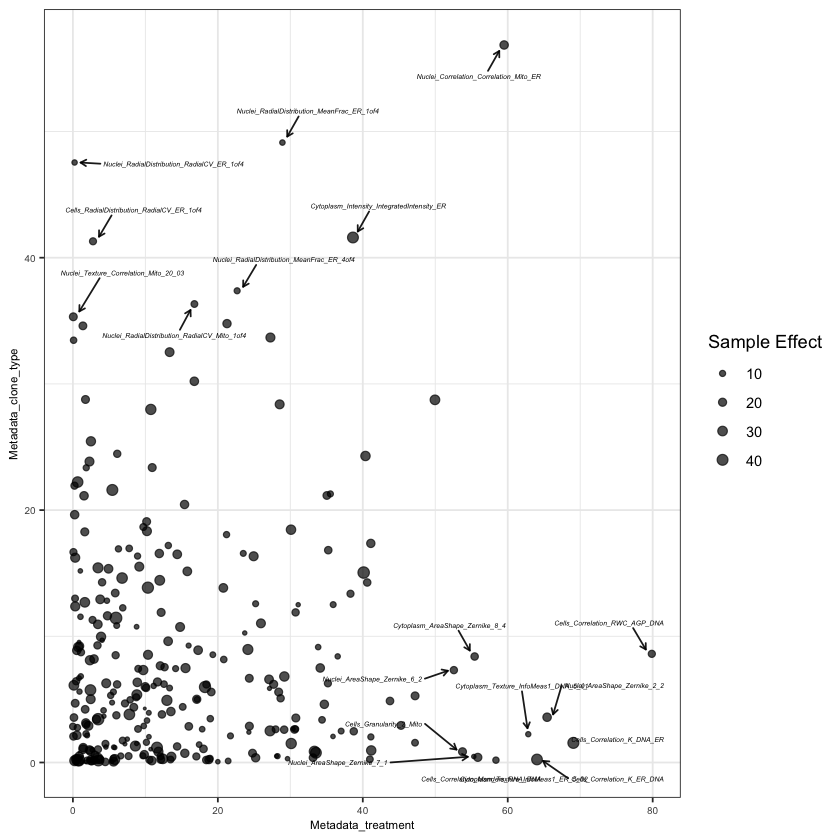

In [9]:
label_logic <- (
    (
        feature_focus_df$Metadata_treatment > 50
    ) | (
        feature_focus_df$Metadata_clone_type > 35
    )
    )

feature_interpret_gg <- ggplot(feature_focus_df,
       aes(x = Metadata_treatment,
           y = Metadata_clone_type,
           size = Metadata_clone_number)) +
    geom_point(alpha = 0.7) + 
    geom_text_repel(data = subset(feature_focus_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.7,
                    point.padding = 0.5,
                    segment.size = 0.5,
                    segment.alpha = 0.9,
                    size = 1.45,
                    fontface = "italic",
                    aes(label = feature,
                        x = Metadata_treatment,
                        y = Metadata_clone_type)) +
    theme_bw() +
    scale_size_continuous(name = "Sample Effect", range = c(0.1, 3)) +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7))

out_file <- file.path("figures", "anova_effect_term_features_clone_type_vs_treatment.png")
ggsave(out_file, dpi = 400, height = 5, width = 5)

feature_interpret_gg

In [10]:
split_feature_df <- full_results_df %>%
        tidyr::separate(feature,
                        into=c("compartment",
                               "feature_group",
                               "measurement",
                               "channel", 
                               "parameter1", 
                               "parameter2"), sep="_", remove=FALSE)

head(split_feature_df)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 1350 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

term,df,sumsq,meansq,statistic,p.value,feature,compartment,feature_group,measurement,channel,parameter1,parameter2,neg_log_p
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Metadata_clone_type,1,20.980116,20.980116,23.999666,1.817242e-06,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,5.7405872
Metadata_treatment,1,7.480601,7.480601,8.557242,3.785997e-03,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,2.4218198
Metadata_batch,2,3.862046,1.931023,2.208944,1.121411e-01,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,0.9502351
Metadata_plate_ID,2,4.230033,2.115017,2.419419,9.123468e-02,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,1.0398400
Metadata_clone_number,7,269.041450,38.434493,43.966152,4.249690e-39,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,38.3716428
Metadata_Well,56,58.195661,1.039208,1.188776,1.905641e-01,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,0.7199588


In [11]:
area_split_df <- split_feature_df %>%
    dplyr::filter(feature_group  == "AreaShape") %>%
    dplyr::group_by(term, compartment, feature_group) %>%
    dplyr::top_n(n = 1, wt = neg_log_p)

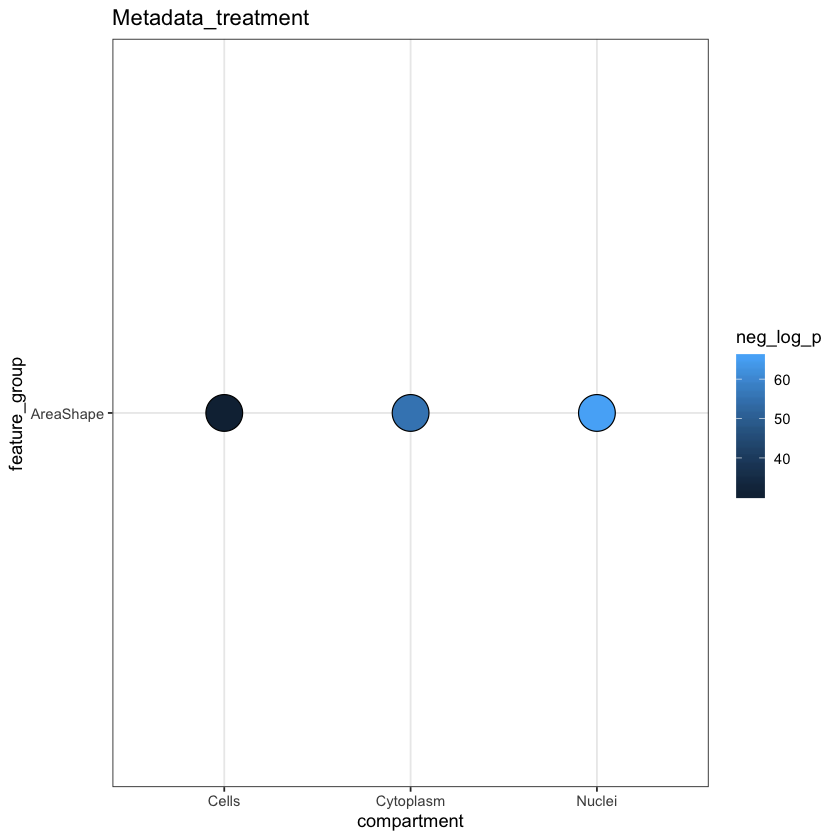

In [12]:
group <- "Metadata_treatment"

ggplot(area_split_df %>% dplyr::filter(term == !!group),
           aes(x = compartment, y = feature_group)) +
    geom_point(aes(fill = neg_log_p), size = 10, pch = 21) +
    ggtitle(group) +
    theme_bw() +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

out_file <- file.path("figures", "anova_effect_term_features_treatment_interpret_area.png")
ggsave(out_file, dpi = 400, height = 3, width = 5)

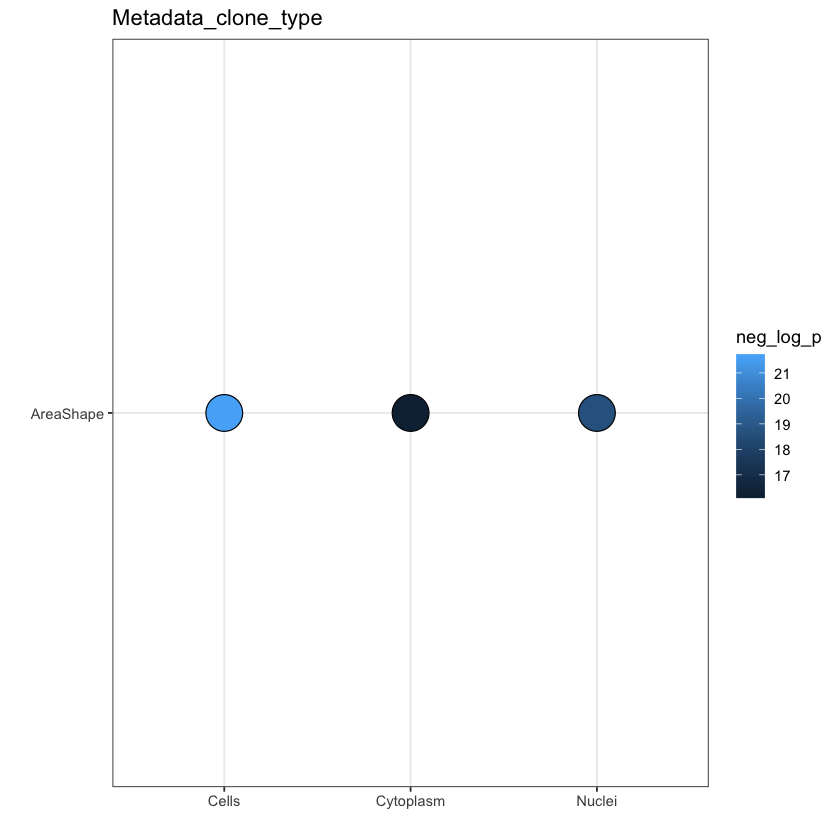

In [13]:
group <- "Metadata_clone_type"

ggplot(area_split_df %>% dplyr::filter(term == !!group),
           aes(x = compartment, y = feature_group)) +
    geom_point(aes(fill = neg_log_p), size = 10, pch = 21) +
    ggtitle(group) +
    theme_bw() +
    ylab("") +
    xlab("") +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

out_file <- file.path("figures", "anova_effect_term_features_clone_type_interpret_area.png")
ggsave(out_file, dpi = 400, height = 2, width = 5)

In [14]:
not_area_split_df <- split_feature_df %>%
    dplyr::filter(
        feature_group %in% c("Texture", "Intensity", "RadialDistribution", "Correlation", "Granularity")) %>%
    dplyr::group_by(term, compartment, feature_group, channel) %>%
    dplyr::top_n(n = 1, wt = neg_log_p)

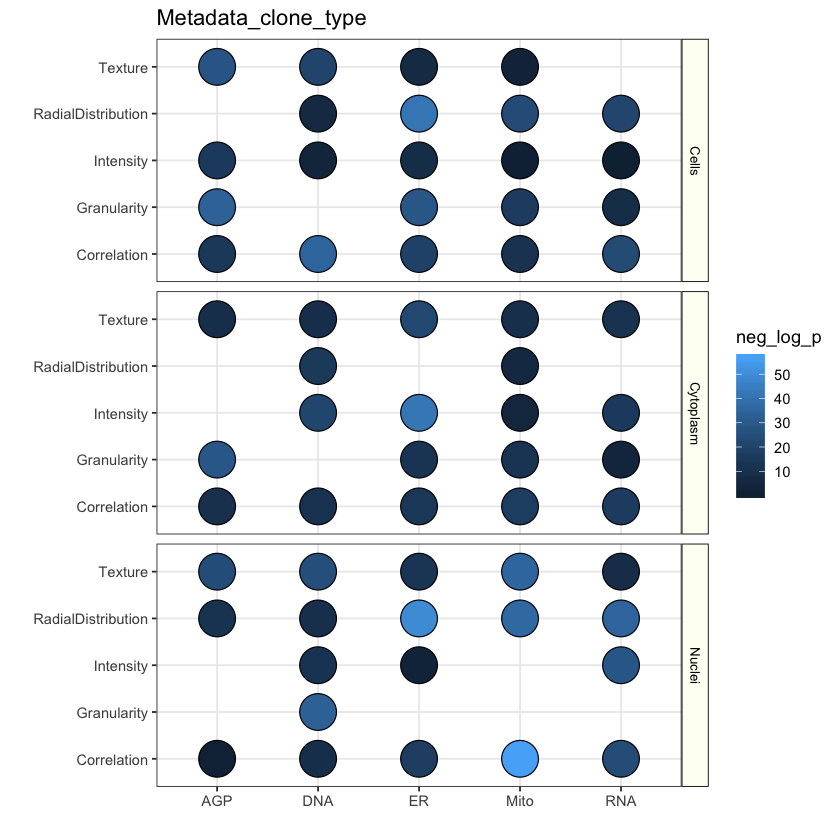

In [15]:
group <- "Metadata_clone_type"

ggplot(not_area_split_df %>% dplyr::filter(term == !!group),
           aes(x = channel, y = feature_group)) +
    geom_point(aes(fill = neg_log_p), size = 10, pch = 21) +
    facet_grid(rows = vars(compartment)) +
    ggtitle(group) +
    theme_bw() +
    ylab("") +
    xlab("") +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

out_file <- file.path("figures", "anova_effect_term_features_clone_type_interpret.png")
ggsave(out_file, dpi = 400, height = 6, width = 5)

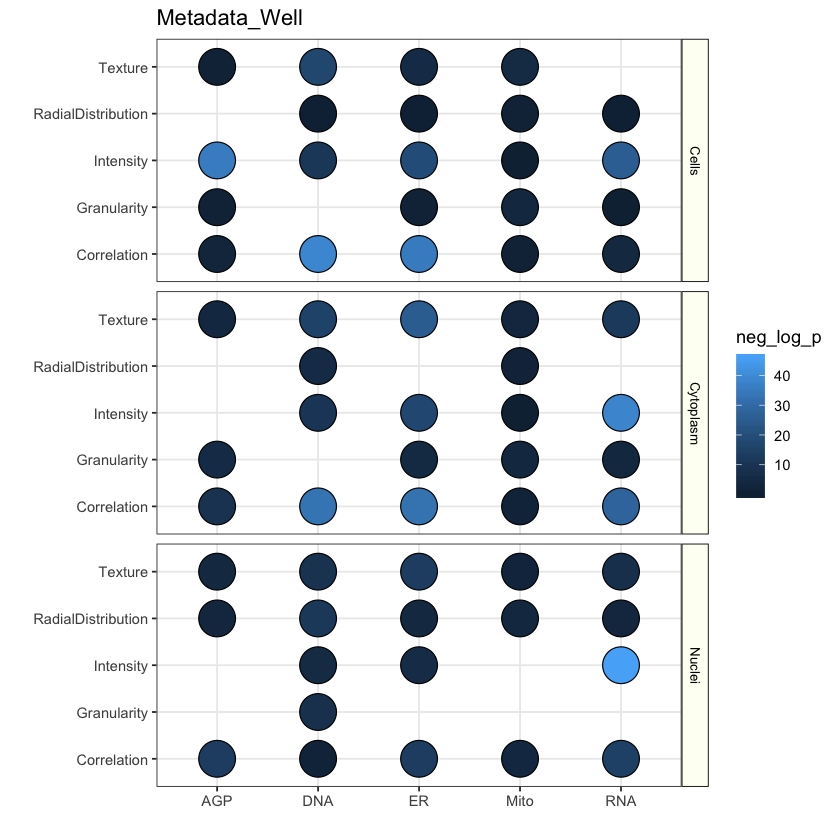

In [16]:
group <- "Metadata_Well"

ggplot(not_area_split_df %>% dplyr::filter(term == !!group),
           aes(x = channel, y = feature_group)) +
    geom_point(aes(fill = neg_log_p), size = 10, pch = 21) +
    facet_grid(rows = vars(compartment)) +
    ggtitle(group) +
    theme_bw() +
    ylab("") +
    xlab("") +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

out_file <- file.path("figures", "anova_effect_term_features_well_interpret.png")
ggsave(out_file, dpi = 400, height = 6, width = 5)

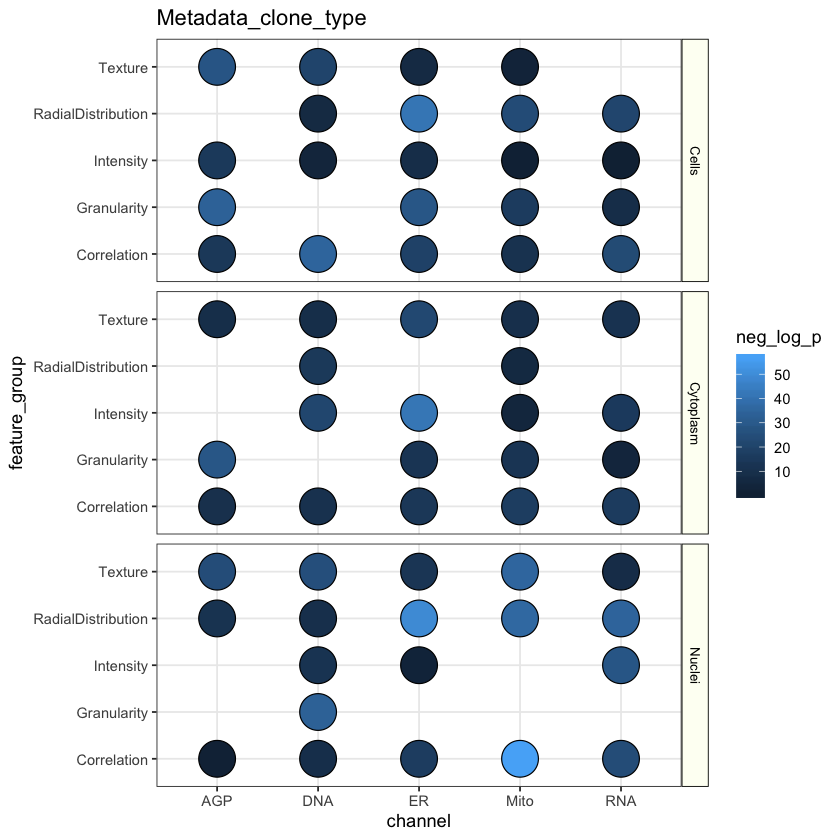

In [17]:
group <- "Metadata_clone_type"

ggplot(not_area_split_df %>% dplyr::filter(term == !!group),
           aes(x = channel, y = feature_group)) +
    geom_point(aes(fill = neg_log_p), size = 10, pch = 21) +
    facet_grid(rows = vars(compartment)) +
    ggtitle(group) +
    theme_bw() +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

out_file <- file.path("figures", "anova_effect_term_features_clone_type_interpret.png")
ggsave(out_file, dpi = 400, height = 6, width = 5)